In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def create_df(path):
    with open(path) as fi:
        data = fi.read()
    data = data.split('\n')


    # construct protein ID and fasta sequence
    prot_id = []
    seqs = []
    for i in range(1, len(data), 2):
        prot_id.append(data[i-1].replace(">", ""))
        seqs.append(data[i])
        
    df = {'Protein ID': prot_id, 'simple_fasta': seqs}
    df = pd.DataFrame(df)
    return df

In [4]:
# make dataframe from every temperature cluster
df1 = create_df('../data/Hyperthermophiliccd_hit_out')
df2 = create_df('../data/Mesophiliccd_hit_out')
df3 = create_df('../data/Thermophiliccd_hit_out')


# concatenate dataframes
frames = [df1, df2, df3]
df = pd.concat(frames)


# merge with filtered dataframe dataframe by Protein ID and simple_fasta
tm_per_seq = pd.read_csv('../data/filtered_data.csv')
filtered_seqs = pd.merge(df, tm_per_seq, how ='inner', on = ['Protein ID', 'simple_fasta'])


# read blind test data and exclude these sequences from train
test = pd.read_csv("../data/ProTstab2 dataset_new/test2_dataset.csv").iloc[:, 1:]
exclude_group = list(set(filtered_seqs['Protein ID']).intersection(set(test['Protein ID'])))
train = filtered_seqs.loc[~filtered_seqs['Protein ID'].isin(exclude_group)]

In [5]:
df = pd.concat([train, test])

In [6]:
df.Tm.max()

98.94

In [9]:
y = df['Tm'].apply(lambda x: 1 if x <= 45 else 2 if (45 < x < 75) else 3)

In [10]:
df['Категория'] = y
df['Protein ID'] = df['Protein ID'].apply(lambda x: x.split('_')[0])

In [11]:
df.head()

,Protein ID,simple_fasta,Species,Tm,Категория
11,A0A0K2H9C7,MKRWLFAVSCAALLLLGGCTTKSEPKRAEPAKPAPRQEQPSKPPAE...,G.stearothermophilus,75.067,3
12,A0A0K2H563,MRIDILTLFPGMFSGVLNESILKKAQEKGAVDIRLIDFREFADNKH...,G.stearothermophilus,75.074,3
13,A0A0K2H825,MHIYRYEENPLITPEDVPPHHDGFEVIGAFNAGVARFQGEVLLLLR...,G.stearothermophilus,75.087,3
14,A0A0K2HAE8,MEEWPLRLFGWFFLSLLANALFASAEAAFSSASKARLRHYAEEHLH...,G.stearothermophilus,75.089,3
15,A0A0K2H9B8,MIERYTRPEMGAIWTEENRFKAWLEVELLACEAWAELGVIPKEDVR...,G.stearothermophilus,75.095,3


In [14]:
group_dict = {'charge' : ['R', 'H', 'K', 'D', 'E'], 'polar': ['S', 'T', 'N', 'Q'],  'cyctein': ['C'], 
             'glicin': ['G'], 'prolin' : ['P'], 'hydr' : ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W']}

In [15]:
ss_df = pd.read_csv('ss_stat.csv')
ss_df.columns = ['Protein ID', 'disord', 'sheet', 'helix', 'sar']

In [16]:
df = df.merge(ss_df, how = 'inner', on = 'Protein ID')

In [17]:
df.Категория.value_counts()

2    10746
1     5798
3     1229
Name: Категория, dtype: int64

In [18]:
one = df[df.Категория==1].sample(n = 1229)
two = df[df.Категория==2].sample(n = 1229)
three = df[df.Категория==3]
overall = pd.concat([one, two, three])

In [19]:
overall.Категория.value_counts()

1    1229
2    1229
3    1229
Name: Категория, dtype: int64

In [20]:
overall.head()

,Protein ID,simple_fasta,Species,Tm,Категория,disord,sheet,helix,sar
1320,Q8VZK9,MVNKDDRIRPVHEADGEPLFETRRRTGRVIAYRFFSASVFVCICLI...,A.thaliana,37.441,1,1926131375466417221127434511334286113243754651...,447712661625241143,2824483123247236416932133424621120411172116133...,33473
6799,R4YMS0,MFKFIRISTHLKKCSALATAILLSACGGTDSTLSTGNSELHVAATQ...,O.antarctica,44.374,1,347263431329193827833,NaN,39244441325391026641841771923,19446
4922,Q7K3L1,MQRHKELYKEQSLVLSPRNHCQENRDRLQAARAKKREDCFYQNRII...,D.melanogaster,41.213,1,125321151341118264119237121043619301812,44,13272843443424312376353301541886,115660
6317,R4YQG8,MNFSSLIIIVIIVLGGAYFLGRNRARTVSNQGLRMHSLPGHYGALM...,O.antarctica,39.463,1,28434462331022383431339,1111,28364153364163321522259296831,26479
4108,Q07085,MGGFLSHLTPEQNVEALKASCGPVRGNIYKHDDVIVDGYLGIPYAK...,C.elegans,41.873,1,9221214623356269222411119107217811112872492111...,23451011277511522717143,1113416622354520111410572831213317720341083,21627


##### count physico-chemical group of aminoacid per sequence

In [43]:
def count_group_aa(group_dict, df):
    seqs = list(df.simple_fasta)
    for key in group_dict:
        stat = []
        for seq in seqs:
            a = 0
            for ch in group_dict[key]:
                a += seq.count(ch)
            stat.append(a)
        df[key] = np.array(stat)
    

In [44]:
count_group_aa(group_dict, overall)

In [23]:
def count_len(df): 
    seqs = list(df.simple_fasta)
    lengths =  np.array([len(seq) for seq in seqs])
    df['length_seq'] = lengths 

In [ ]:
count_len(overall)

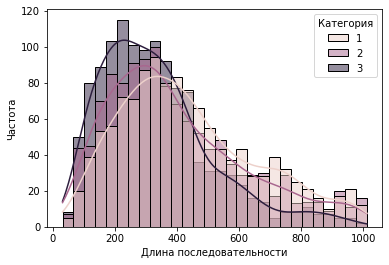

In [25]:
z = sns.histplot(overall, x='length_seq', hue='Категория',  kde=True);
z.set_xlabel('Длина последовательности')
z.set_ylabel('Частота')
plt.show()

In [29]:
overall['charge_norm'] = overall['charge']/overall['length_seq']

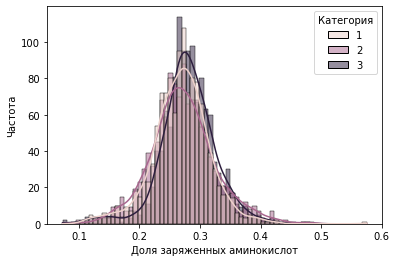

In [30]:
z = sns.histplot(overall, x='charge_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля заряженных аминокислот')
z.set_ylabel('Частота')
plt.show()

In [31]:
overall[overall['Категория']==3].charge.median()

80.0

In [33]:
overall['polar_norm'] = overall['polar']/overall['length_seq']

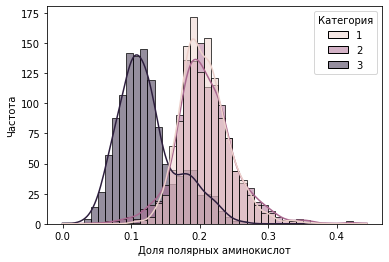

In [34]:
z = sns.histplot(overall, x='polar_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля полярных аминокислот')
z.set_ylabel('Частота')
plt.show();

In [35]:
overall['hydr_norm'] = overall['hydr']/overall['length_seq']

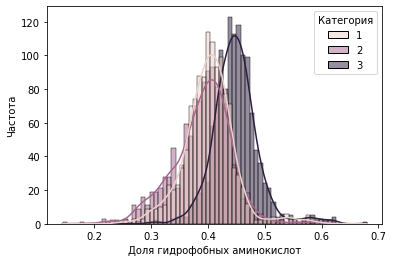

In [38]:
z = sns.histplot(overall, x='hydr_norm', hue='Категория',  kde=True)
z.set_xlabel('Доля гидрофобных аминокислот')
z.set_ylabel('Частота')
plt.show()

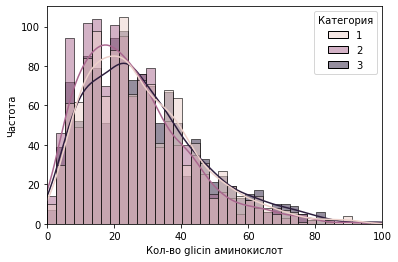

In [39]:
z = sns.histplot(overall, x='glicin', hue='Категория',  kde=True)
z.set_xlabel('Кол-во glicin аминокислот')
z.set_ylabel('Частота')
z.set_xlim(0, 100)
plt.show()

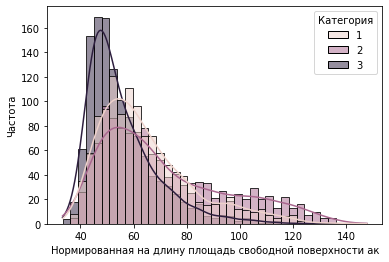

In [40]:
overall['sar_normalized'] = overall.sar/overall.length_seq # normalized sar
z = sns.histplot(data=overall, x='sar_normalized', hue='Категория',  kde=True)
z.set_xlabel('Нормированная на длину площадь свободной поверхности ак')
z.set_ylabel('Частота')
plt.show()